In [4]:
# Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import linregress
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold



import random
import datetime as dt
import time


from sklearn import preprocessing
import tensorflow as tf

import import_ipynb
import sys

import network_arch as network
import metrics
import plot
import settings 


In [5]:
# --- Inline Settings ---
HIDDENS = [128, 32]  # Hidden layer sizes
NLABEL = 2  # Binary classification (positive/negative NAO)
RIDGE1 = 5.0  # L2 regularization
DROPOUT = 0.0  # Dropout rate
LR_INIT = 6.7e-6  # Initial learning rate
NETWORK_SEED = 42  # Random seed
BATCH_SIZE = 512  # Batch size
EPOCHS = 1000  # Number of epochs

In [6]:
# --- Custom Metric: PredictionAccuracy ---
class PredictionAccuracy(tf.keras.metrics.Metric):
    def __init__(self, nlabel, name='prediction_accuracy', **kwargs):
        super(PredictionAccuracy, self).__init__(name=name, **kwargs)
        self.nlabel = nlabel
        self.correct = self.add_weight(name='correct', initializer='zeros')
        self.total = self.add_weight(name='total', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=1)
        y_pred = tf.argmax(y_pred, axis=1)
        correct = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
        total = tf.cast(tf.size(y_true), tf.float32)
        self.correct.assign_add(correct)
        self.total.assign_add(total)

    def result(self):
        return self.correct / self.total

    def reset_states(self):
        self.correct.assign(0.0)
        self.total.assign(0.0)

In [7]:
# --- Neural Network Architecture ---
def defineNN(hiddens, input1_shape, output_shape, ridge_penalty1, dropout, act_fun, network_seed):
    tf.random.set_seed(network_seed)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(input1_shape,)))
    for units in hiddens:
        model.add(tf.keras.layers.Dense(
            units,
            activation=act_fun,
            kernel_regularizer=tf.keras.regularizers.l2(ridge_penalty1)
        ))
        if dropout > 0:
            model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(output_shape, activation='softmax'))
    return model

def make_model(input_shape):
    tf.keras.backend.clear_session()
    model = defineNN(
        HIDDENS,
        input1_shape=input_shape,
        output_shape=NLABEL,
        ridge_penalty1=RIDGE1,
        dropout=DROPOUT,
        act_fun='relu',
        network_seed=NETWORK_SEED
    )
    loss_function = tf.keras.losses.CategoricalCrossentropy()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LR_INIT),
        loss=loss_function,
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy"),
            PredictionAccuracy(NLABEL)
        ]
    )
    return model, loss_function

import math

def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    return float(lr * math.exp(-0.1))

In [8]:
# --- Preprocessing ---
# Detrend function
def detrend_data(data, dim='valid_time'):
    if dim not in data.dims or data.sizes[dim] == 0:
        raise ValueError(f"Dimension {dim} not found or empty")
    time_vals = (data[dim] - data[dim][0]) / np.timedelta64(1, 'D')
    def detrend_ufunc(t, y):
        if np.all(np.isnan(y)) or len(np.unique(y[~np.isnan(y)])) < 2:
            return y
        slope, intercept, _, _, _ = linregress(t, y)
        return y - (slope * t + intercept)
    detrended = xr.apply_ufunc(
        detrend_ufunc, time_vals, data,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[dim]],
        vectorize=True
    )
    return detrended

In [9]:
nc_psl = r"C:/Users/31610/Documents/UvA/Master thesis/Data/CESM2 Data/merged_nao_data_1850-2014.nc"

# Opening the NETCDF files using xarray
nao_data = xr.open_dataset(nc_psl)
# Rename PSL to msl and time to valid_time
nao_data = nao_data.rename({'PSL': 'msl', 'time': 'valid_time'})


<xarray.Dataset> Size: 670MB
Dimensions:     (valid_time: 24916, latitude: 64, longitude: 105)
Coordinates:
  * valid_time  (valid_time) object 199kB 1850-01-01 00:00:00 ... 2015-01-01 ...
  * longitude   (longitude) float64 840B 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * latitude    (latitude) float64 512B 20.26 21.2 22.15 ... 77.75 78.69 79.63
Data variables:
    msl         (valid_time, latitude, longitude) float32 670MB ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BHISTcmip6.f09_g17.LE2-1001.001
    logname:           sunseon
    host:              mom1
    initial_file:      b.e21.B1850.f09_g17.CMIP6-piControl.001.cam.i.1001-01-...
    topography_file:   /mnt/lustre/share/CESM/cesm_input/atm/cam/topo/fv_0.9x...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  day_1


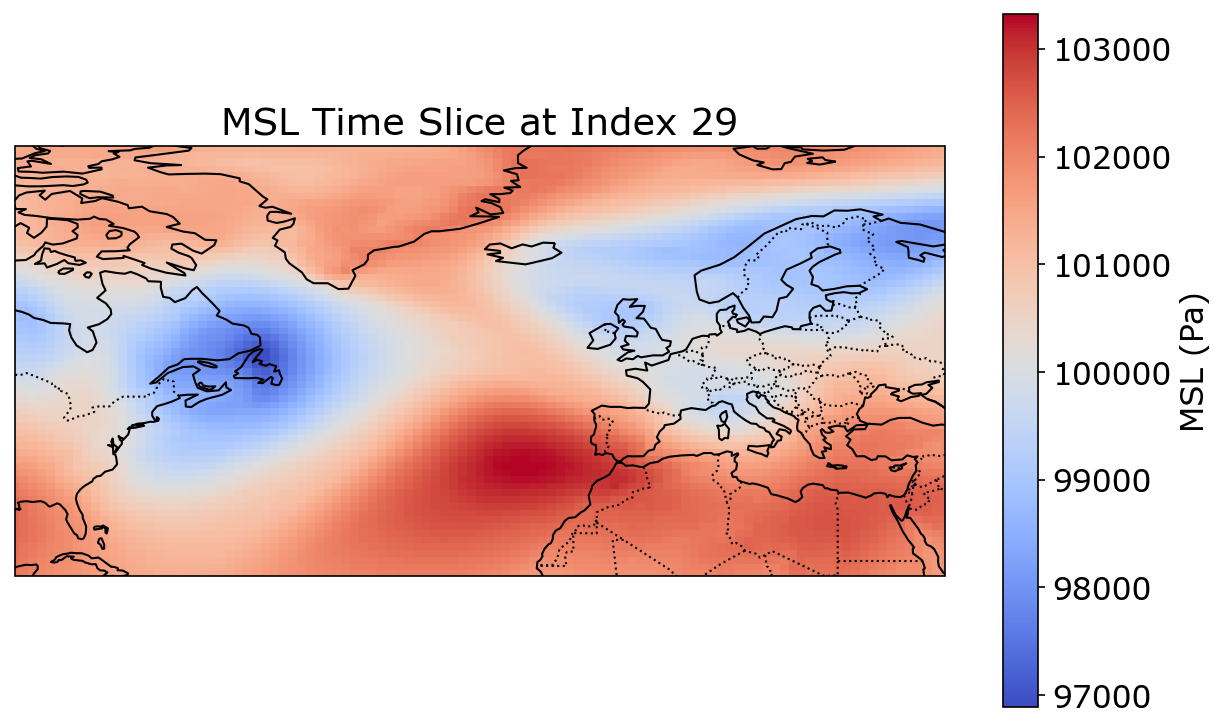

In [10]:
# Visualizing a time slice of the data with land boundaries and limited range
def plot_time_slice_with_boundaries_limited(data, time_index):
    # Disable LaTeX rendering in Matplotlib to avoid the error
    plt.rcParams['text.usetex'] = False
    plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(resolution='110m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    # Ensure longitudes are sorted
    data = data.sortby('longitude')

    # Get the range of latitude and longitude
    lat_min = data['latitude'].values.min()
    lat_max = data['latitude'].values.max()
    lon_min = data['longitude'].values.min()
    lon_max = data['longitude'].values.max()

    # Set the extent of the plot to match the data range
    ax.set_extent([-90, 40, 20, 80], crs=ccrs.PlateCarree())

    # Plot the data
    data['msl'].isel(valid_time=time_index).plot(
        ax=ax, x='longitude', y='latitude', cmap='coolwarm', cbar_kwargs={'label': 'MSL (Pa)'},
        transform=ccrs.PlateCarree()
    )
    plt.title(f'MSL Time Slice at Index {time_index}')
    plt.xlabel('Longitude (°E)')
    plt.ylabel('Latitude (°N)')
    plt.show()

# Plotting the first time slice with limited range
print(nao_data)
plot_time_slice_with_boundaries_limited(nao_data, 29)

In [11]:



# Compute anomalies
climatology = nao_data['msl'].mean(dim='valid_time')
X_all = nao_data['msl'] - climatology

# Detrend
X_all_detrended = detrend_data(X_all)

# Flatten and standardize
X_all_flat = X_all_detrended.stack(z=('latitude', 'longitude')).transpose('valid_time', 'z')
X_all_mean = X_all_flat.mean(dim='valid_time')
X_all_std_dev = X_all_flat.std(dim='valid_time')
X_all_std_dev = xr.where(X_all_std_dev == 0, 1, X_all_std_dev)  # Avoid division by zero
X_all_normalized = (X_all_flat - X_all_mean) / X_all_std_dev
print("X_all_normalized shape:", X_all_normalized.shape)


X_all_normalized shape: (24916, 6720)


In [12]:
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import cftime

# Debugging: Check coordinates and data
print("nao_data coordinates:", nao_data.coords)
print("Latitude range:", nao_data['latitude'].values.min(), "to", nao_data['latitude'].values.max())
print("Longitude range:", nao_data['longitude'].values.min(), "to", nao_data['longitude'].values.max())

# Define NAO regions
iceland = nao_data.sel(latitude=slice(65, 70), longitude=slice(340, 350))
azores = nao_data.sel(latitude=slice(35, 40), longitude=slice(325, 335))

# Compute means over regions
iceland = iceland.mean(dim=['latitude', 'longitude'])
azores = azores.mean(dim=['latitude', 'longitude'])

# Compute NAO index and name it
nao_index = azores['msl'] - iceland['msl']
nao_index = nao_index.rename('nao_index')  # Assign a name for clarity
print("NAO Index shape:", nao_index.shape)
print("NAO Index values:", nao_index.values)

# Check time coordinate
time_coord = 'valid_time' if 'valid_time' in nao_index.coords else 'time'
print(f"Using time coordinate: {time_coord}")
print(f"Original {time_coord} values:", nao_index[time_coord].values)

# Convert time to datetime64 format
if isinstance(nao_index[time_coord].values[0], (cftime.datetime, cftime.DatetimeNoLeap)):
    dates = pd.to_datetime([d.strftime() for d in nao_index[time_coord].values])
    nao_index[time_coord] = dates
else:
    nao_index[time_coord] = pd.to_datetime(nao_index[time_coord].values, errors='coerce')

print(f"Converted {time_coord} values:", nao_index[time_coord].values)

# Check for NaT values
if np.all(pd.isna(nao_index[time_coord].values)):
    raise ValueError("All time values are NaT. Check time decoding in earlier steps or dataset structure.")

# Apply 21-day lead time
lead = 21  # 21 days lead
days_average = 14  # 14-day rolling average (adjust if data is 48-hour)

# Shift the time coordinate
shifted_time = nao_index[time_coord] + pd.Timedelta(days=lead)
print("Shifted time:", shifted_time.values)

# Assign the shifted time
nao_index_shifted = nao_index.assign_coords({time_coord: shifted_time})

# Check time resolution
time_diff = nao_index_shifted[time_coord].diff(time_coord)
print("Time difference between consecutive points:", time_diff.values)
if np.all(time_diff == pd.Timedelta(days=2)):
    days_average = 7  # Adjust for 48-hour data
    print("Adjusted days_average to 7 for 48-hour data.")

# Apply rolling average with min_periods to handle edges
Y_all = nao_index_shifted.rolling(**{time_coord: days_average}, center=True, min_periods=1).mean()
print("Y_all shape:", Y_all.shape)
print("Y_all values:", Y_all.values)
print("Number of NaNs in Y_all:", np.sum(np.isnan(Y_all.values)))

# Handle NaNs due to rolling
valid_indices = np.where(~np.isnan(Y_all))[0]
Y_all = Y_all.isel(**{time_coord: valid_indices})

# Debug: Print values before alignment
print("Y_all values after trimming NaNs:", Y_all.values)

# Align X_all_normalized with Y_all
if 'X_all_normalized' in globals():
    X_all_normalized = X_all_normalized.isel(**{time_coord: valid_indices})
    print("X_all_normalized shape after alignment:", X_all_normalized.shape)
else:
    print("X_all_normalized not defined. Ensure it’s loaded before this step.")

# Binarize based on median
Ytrain_med = np.median(Y_all)
Y_all_binary = xr.where(Y_all >= Ytrain_med, 1, 0)
print("Y_all_binary shape:", Y_all_binary.shape)

# One-hot encode
enc = OneHotEncoder(sparse_output=False)
Y_all_onehot = enc.fit_transform(Y_all_binary.values.reshape(-1, 1))
print("Y_all_onehot shape:", Y_all_onehot.shape)

nao_data coordinates: Coordinates:
  * valid_time  (valid_time) object 199kB 1850-01-01 00:00:00 ... 2015-01-01 ...
  * longitude   (longitude) float64 840B 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * latitude    (latitude) float64 512B 20.26 21.2 22.15 ... 77.75 78.69 79.63
Latitude range: 20.26178010471204 to 79.63350785340315
Longitude range: 0.0 to 358.75
NAO Index shape: (24916,)
NAO Index values: [2305.3203 2639.7812 3801.8125 ... 6119.828  5298.7188 5108.789 ]
Using time coordinate: valid_time
Original valid_time values: [cftime.DatetimeNoLeap(1850, 1, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1850, 1, 2, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1850, 1, 3, 0, 0, 0, 0, has_year_zero=True) ...
 cftime.DatetimeNoLeap(2014, 12, 30, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2014, 12, 31, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2015, 1, 1, 0, 0, 0, 0, has_year_zero=True)]
Converted valid_time values: ['1850-01-01T00:00:00.0000

In [13]:
print(nao_index_shifted)

<xarray.DataArray 'nao_index' (valid_time: 24916)> Size: 100kB
array([2305.3203, 2639.7812, 3801.8125, ..., 6119.828 , 5298.7188,
       5108.789 ], dtype=float32)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 199kB 1850-01-22 ... 2015-01-22


In [14]:
# --- Class Balancing ---
pos_indices = np.where(Y_all_binary == 1)[0]
neg_indices = np.where(Y_all_binary == 0)[0]
n_samples = min(len(pos_indices), len(neg_indices))
pos_subset = np.random.choice(pos_indices, n_samples, replace=False)
neg_subset = np.random.choice(neg_indices, n_samples, replace=False)
# Ensure balanced_indices are valid for X_all_normalized and Y_all_onehot
balanced_indices = np.concatenate([pos_subset, neg_subset])
# Ensure balanced_indices are within the valid range of X_all_normalized and Y_all_onehot
balanced_indices = balanced_indices[balanced_indices < len(X_all_normalized)]

# Apply the balanced indices
X_all_normalized = X_all_normalized.isel(valid_time=balanced_indices)
Y_all_onehot = Y_all_onehot[balanced_indices]
print("X_all_normalized balanced shape:", X_all_normalized.shape)
print("Y_all_onehot balanced shape:", Y_all_onehot.shape)

# Add this after balancing to verify class balance
balanced_labels = np.argmax(Y_all_onehot, axis=1)
classes, counts = np.unique(balanced_labels, return_counts=True)

for c, n in zip(classes, counts):
    print(f"Class {c}: {n} samples")


X_all_normalized balanced shape: (24916, 6720)
Y_all_onehot balanced shape: (24916, 2)
Class 0: 12458 samples
Class 1: 12458 samples


In [16]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Assuming X_all_normalized and Y_all_onehot are ready, with labels one-hot encoded

# Step 1: Convert one-hot labels back to class integers for stratified splitting
Y_all_classes = np.argmax(Y_all_onehot, axis=1)

# Step 2: Split into train (80%) and temp (20%) stratified by class labels
X_train, X_temp, y_train_classes, y_temp_classes, Y_train, Y_temp = train_test_split(
    X_all_normalized, Y_all_classes, Y_all_onehot,
    stratify=Y_all_classes,
    test_size=0.2,
    random_state=42
)

# Step 3: Split temp into validation (10%) and test (10%) - half and half from temp
X_val, X_test, y_val_classes, y_test_classes, Y_val, Y_test = train_test_split(
    X_temp, y_temp_classes, Y_temp,
    stratify=y_temp_classes,
    test_size=0.5,
    random_state=42
)

# Check the distribution to verify
print("Train distribution:", dict(zip(*np.unique(y_train_classes, return_counts=True))))
print("Validation distribution:", dict(zip(*np.unique(y_val_classes, return_counts=True))))
print("Test distribution:", dict(zip(*np.unique(y_test_classes, return_counts=True))))

# Step 5: Train your model (assuming make_model is your model builder function)
model, loss_function = make_model(input_shape=X_all_normalized.shape[1])
history = model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val),
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.LearningRateScheduler(scheduler)
    ]
)

# You can now evaluate on your test set using:
# model.evaluate(X_test, Y_test)




Train distribution: {np.int64(0): np.int64(9966), np.int64(1): np.int64(9966)}
Validation distribution: {np.int64(0): np.int64(1246), np.int64(1): np.int64(1246)}
Test distribution: {np.int64(0): np.int64(1246), np.int64(1): np.int64(1246)}
Epoch 1/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - categorical_accuracy: 0.4808 - loss: 1507.3608 - prediction_accuracy: 0.4808 - val_categorical_accuracy: 0.5052 - val_loss: 1481.9045 - val_prediction_accuracy: 0.5052 - learning_rate: 6.7000e-06
Epoch 2/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - categorical_accuracy: 0.5124 - loss: 1473.5575 - prediction_accuracy: 0.5124 - val_categorical_accuracy: 0.5305 - val_loss: 1448.7120 - val_prediction_accuracy: 0.5305 - learning_rate: 6.7000e-06
Epoch 3/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - categorical_accuracy: 0.5347 - loss: 1440.5719 - prediction_accuracy: 0.5347 - val_categorical_accuracy: 0.5482 - val_loss: 1416.3392 - val_prediction_accuracy: 0.5482 - learning_rate: 6.7000e-06
Epoch 

In [17]:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
# Decode Y_train from one-hot to labels
y_train_labels = np.argmax(Y_train, axis=1)
print("Y_train class distribution:", np.bincount(y_train_labels))

# Assuming you have X_val and Y_val (e.g., from a 80/20 split)
# Decode Y_val similarly if available
print(Y_val)
y_val_labels = np.argmax(Y_val, axis=1)
print(y_val_labels[500:1500])
print("Y_val class distribution:", np.bincount(y_val_labels))
print("Y_val unique labels:", np.unique(y_val_labels))
# Check original Y_all_binary distribution
print("Original Y_all_binary distribution:", np.bincount(Y_all_binary))


X_train shape: (19932, 6720)
Y_train shape: (19932, 2)
Y_train class distribution: [9966 9966]
[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]
[0 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1
 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 0 1 0
 1 0 1 1 0 1 1 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 0 1 0 0 1 0 1 1 0
 1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0
 0 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0
 0 1 0 0 1 1 1 0 1 0 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1
 0 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0
 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0 1 0 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 0 0 1 0
 1 1 1 1 0 1 0 0 0 0 1 0 1 1 1 1 0 1 0 0 0 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1 1
 0 0 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 0 1 1 1 1 0 1 1 1
 0 0 1 0 0 0 1 1 1 1

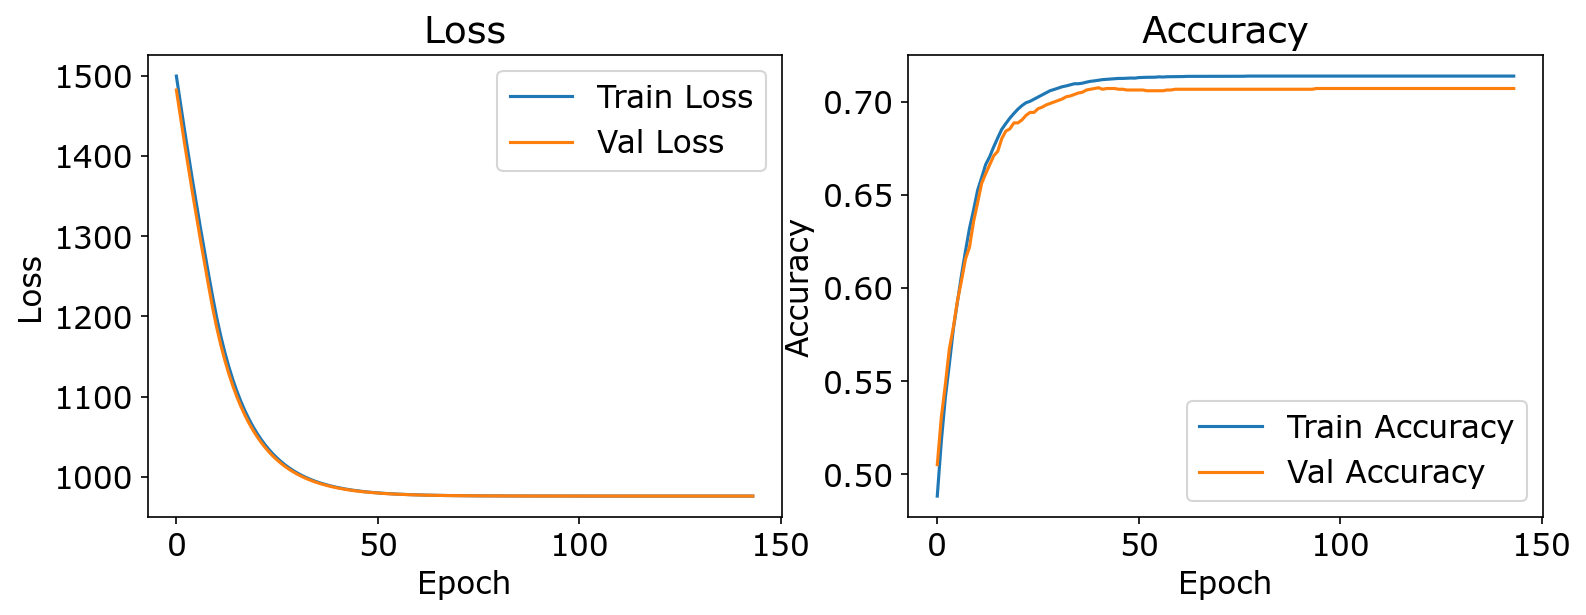

In [18]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_history.png')
plt.show()

In [19]:
# Evaluate on test set
test_loss, test_accuracy, test_pred_accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Prediction Accuracy: {test_pred_accuracy:.4f}")


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.7132 - loss: 976.2189 - prediction_accuracy: 0.7132
Test Loss: 976.2154, Accuracy: 0.7171, Prediction Accuracy: 0.7171


In [20]:
from sklearn.ensemble import RandomForestClassifier
# Create classifier with class_weight to handle imbalance
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
# Fit model
clf.fit(X_train, Y_train)

# Predict
y_pred = clf.predict(X_val)

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


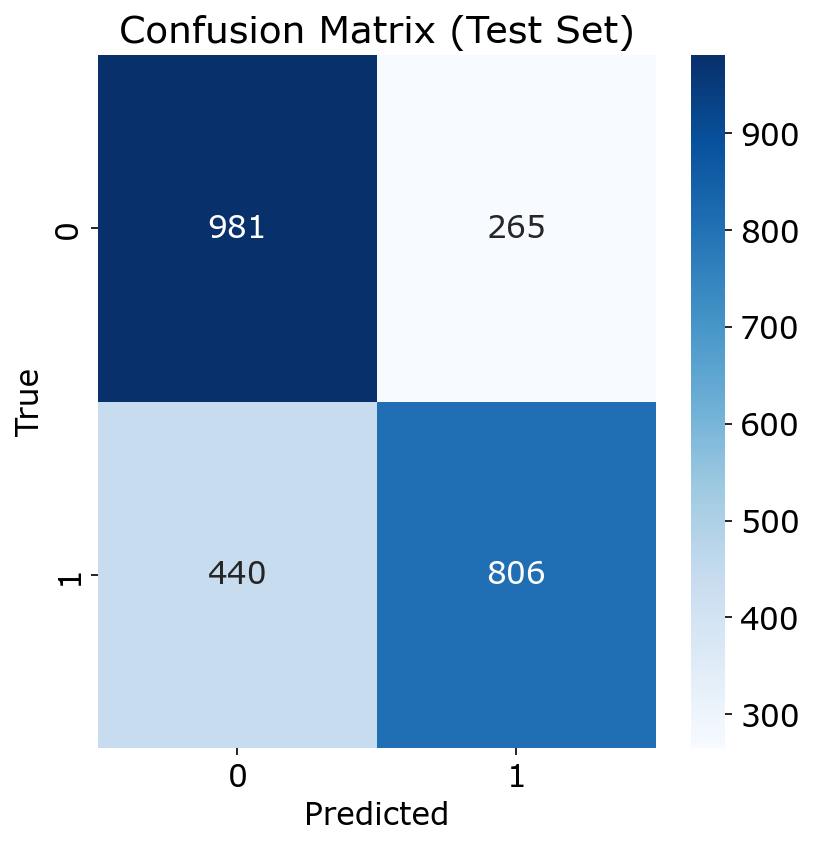

In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict on test set
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(Y_test_classes, Y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.savefig('confusion_matrix.png')
plt.show()


In [22]:
Y_pred_full_probs = model.predict(X_all_normalized)
print("Y_pred_full_probs shape:", Y_pred_full_probs[10])

779/779 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Y_pred_full_probs shape: [0.63948774 0.3605123 ]


In [23]:
# Check the probability distribution for the first few samples
print("Predicted probabilities for first few samples:", Y_pred_full_probs[30:40])

Predicted probabilities for first few samples: [[0.5951923  0.40480772]
 [0.39598387 0.60401607]
 [0.21322043 0.7867795 ]
 [0.51404643 0.48595357]
 [0.61967987 0.38032004]
 [0.48799294 0.5120071 ]
 [0.30543363 0.69456637]
 [0.46246213 0.5375379 ]
 [0.15531316 0.84468687]
 [0.26275393 0.73724604]]


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


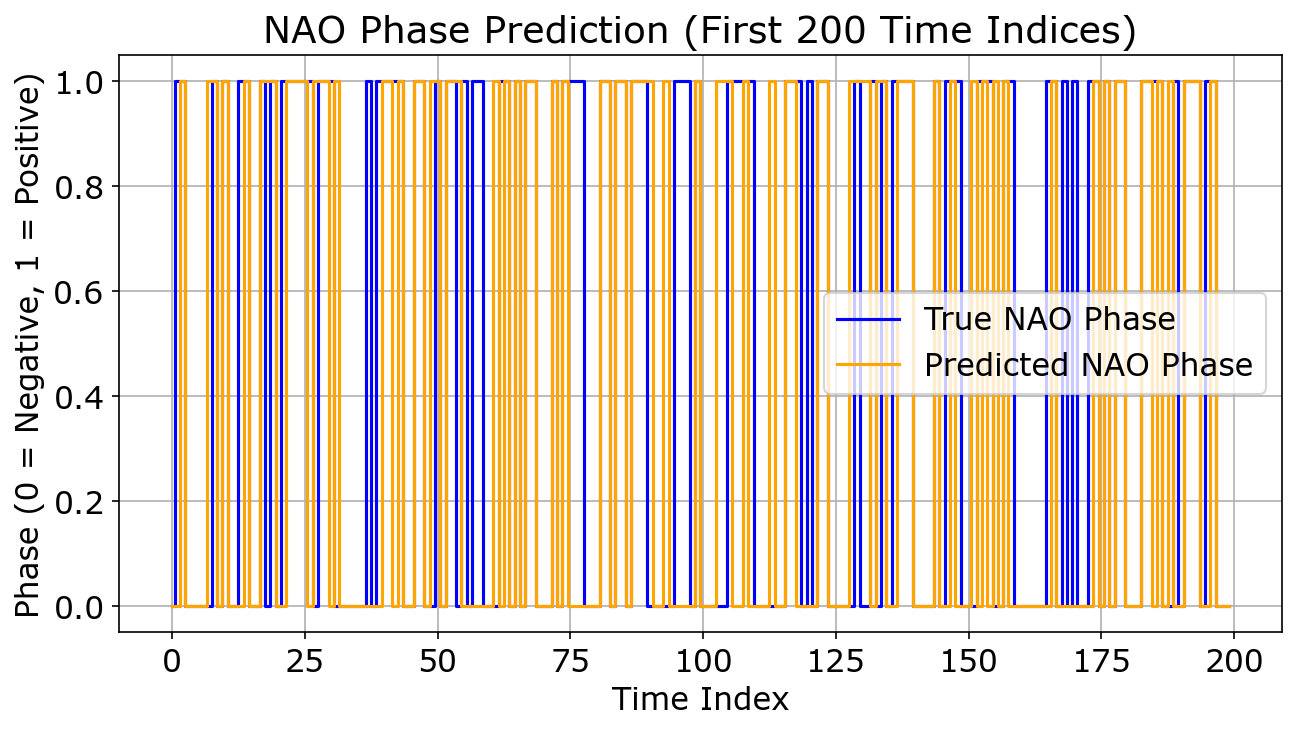

In [24]:
# Step 1: Predict NAO phases for the entire validation set
y_pred = model.predict(X_val)  # Get probabilities for all samples
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices (0 or 1)

# Step 2: Convert true labels to class indices
y_true_classes = np.argmax(Y_val, axis=1)  # Assuming y_val is one-hot encoded

subset_size = 200
plt.figure(figsize=(10, 5))
plt.step(range(subset_size), y_true_classes[:subset_size], label="True NAO Phase", color="blue", where="mid")
plt.step(range(subset_size), y_pred_classes[:subset_size], label="Predicted NAO Phase", color="orange", where="mid")
plt.title("NAO Phase Prediction (First 200 Time Indices)")
plt.xlabel("Time Index")
plt.ylabel("Phase (0 = Negative, 1 = Positive)")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_input_field_with_prediction(input_data, lats, lons, prediction, title_prefix="Model Prediction"):
    """
    Visualize a single input field (e.g., SLP) with a predicted label.

    Parameters:
    - input_data: 2D array of shape (lat x lon), the field to plot (e.g., SLP)
    - lats, lons: 1D or 2D arrays of latitude and longitude values
    - prediction: int, predicted class label (e.g., 0 or 1)
    - title_prefix: str, custom prefix for the title
    """
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import numpy as np

    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    # Set the extent of the plot to match the data range
    ax.set_extent([-90, 40, 20, 80], crs=ccrs.PlateCarree())

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

    if lats.ndim == 1 and lons.ndim == 1:
        lons, lats = np.meshgrid(lons, lats)

    contour = ax.contourf(
    lons, lats, input_data,
    cmap='coolwarm',  # Adjust based on expected range
    transform=ccrs.PlateCarree()
)

    plt.colorbar(contour, ax=ax, orientation='vertical', label='SLP (hPa)')

    ax.set_title(f"{title_prefix}: {'Positive NAO' if prediction == 1 else 'Negative NAO'}", fontsize=14)
    plt.tight_layout()
    plt.show()


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_input_field_with_prediction(input_data, lats, lons, prediction, title_prefix="Model Prediction"):
    """
    Visualize a single input field (e.g., SLP) with a predicted label.

    Parameters:
    - input_data: 2D array of shape (lat x lon), the field to plot (e.g., SLP)
    - lats, lons: 1D or 2D arrays of latitude and longitude values
    - prediction: int, predicted class label (e.g., 0 or 1)
    - title_prefix: str, custom prefix for the title
    """
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import numpy as np

    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    # Set the extent of the plot to match the data range
    ax.set_extent([-90, 40, 20, 80], crs=ccrs.PlateCarree())

    # Default Cartopy styling for land and ocean (remove custom colors)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Add gridlines for better readability
    ax.gridlines(draw_labels=True, linestyle='--', color='black', alpha=0.5)

    if lats.ndim == 1 and lons.ndim == 1:
        lons, lats = np.meshgrid(lons, lats)

    # Define levels for discrete color steps (every 4 hPa from 980 to 1030)
    levels = np.arange(980, 1032, 4)  # 980, 984, ..., 1028

    # Filled contours with a colormap that includes both blue and red
    contour = ax.contourf(
        lons, lats, input_data,
        levels=levels,
        cmap='coolwarm',  # Keep coolwarm for blue (low) and red (high)
        transform=ccrs.PlateCarree(),
        extend='both'  # Allow values outside the range
    )

    # Enhanced colorbar with specific ticks
    cbar = plt.colorbar(contour, ax=ax, orientation='vertical', label='SLP (hPa)', ticks=levels)
    cbar.ax.tick_params(labelsize=10)

    ax.set_title(f"{title_prefix}: {'Positive NAO' if prediction == 1 else 'Negative NAO'}", fontsize=14)
    plt.tight_layout()
    plt.show()

 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


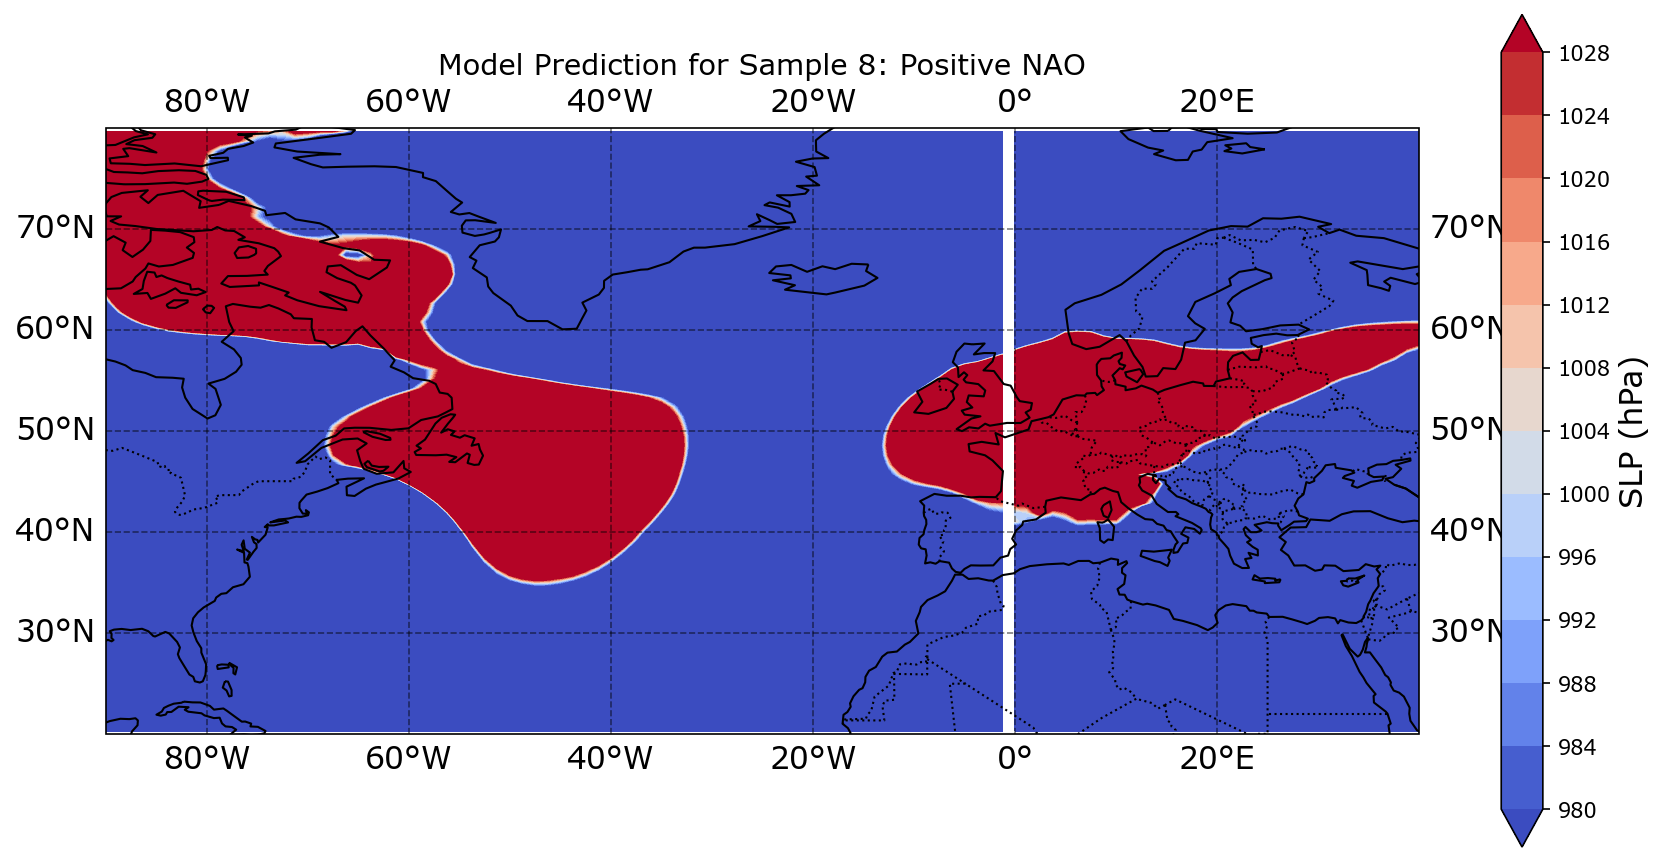

In [27]:
# Step 1: Select a time step
sample_idx = 8
  # You can change this index to any sample

# Step 2: Extract flattened input
sample_input = X_val[sample_idx]

# Step 3: De-normalize using the stored climatology mean and std dev
sample_input_unnorm = (sample_input * X_all_std_dev) + X_all_mean

# Step 4: Reshape to 2D grid (lat x lon)
sample_input_2d = sample_input_unnorm.values.reshape(len(nao_data.latitude), len(nao_data.longitude))

# Step 5: Predict NAO class
sample_pred = np.argmax(model.predict(X_val[sample_idx:sample_idx+1]), axis=1)[0]

# Step 6: Plot using your function
plot_input_field_with_prediction(
    sample_input_2d,
    nao_data.latitude.values,
    nao_data.longitude.values,
    sample_pred,
    title_prefix=f"Model Prediction for Sample {sample_idx}"
)




X_val shape: (2492, 6720)
X_val range: -8.607506538575636 4.213546199392989
X_all_mean shape: (6720,)
X_all_mean range: -7.21190007517161e-06 7.834101900923736e-06
X_all_std_dev shape: (6720,)
X_all_std_dev range: 208.2892875565801 1688.2635361761868
Latitudes: 64 Longitudes: 105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Model prediction: [[0.8543545  0.14564548]]
ig_attributions shape: (1, 6720)
ig_attributions range: -0.021558467 0.024664743


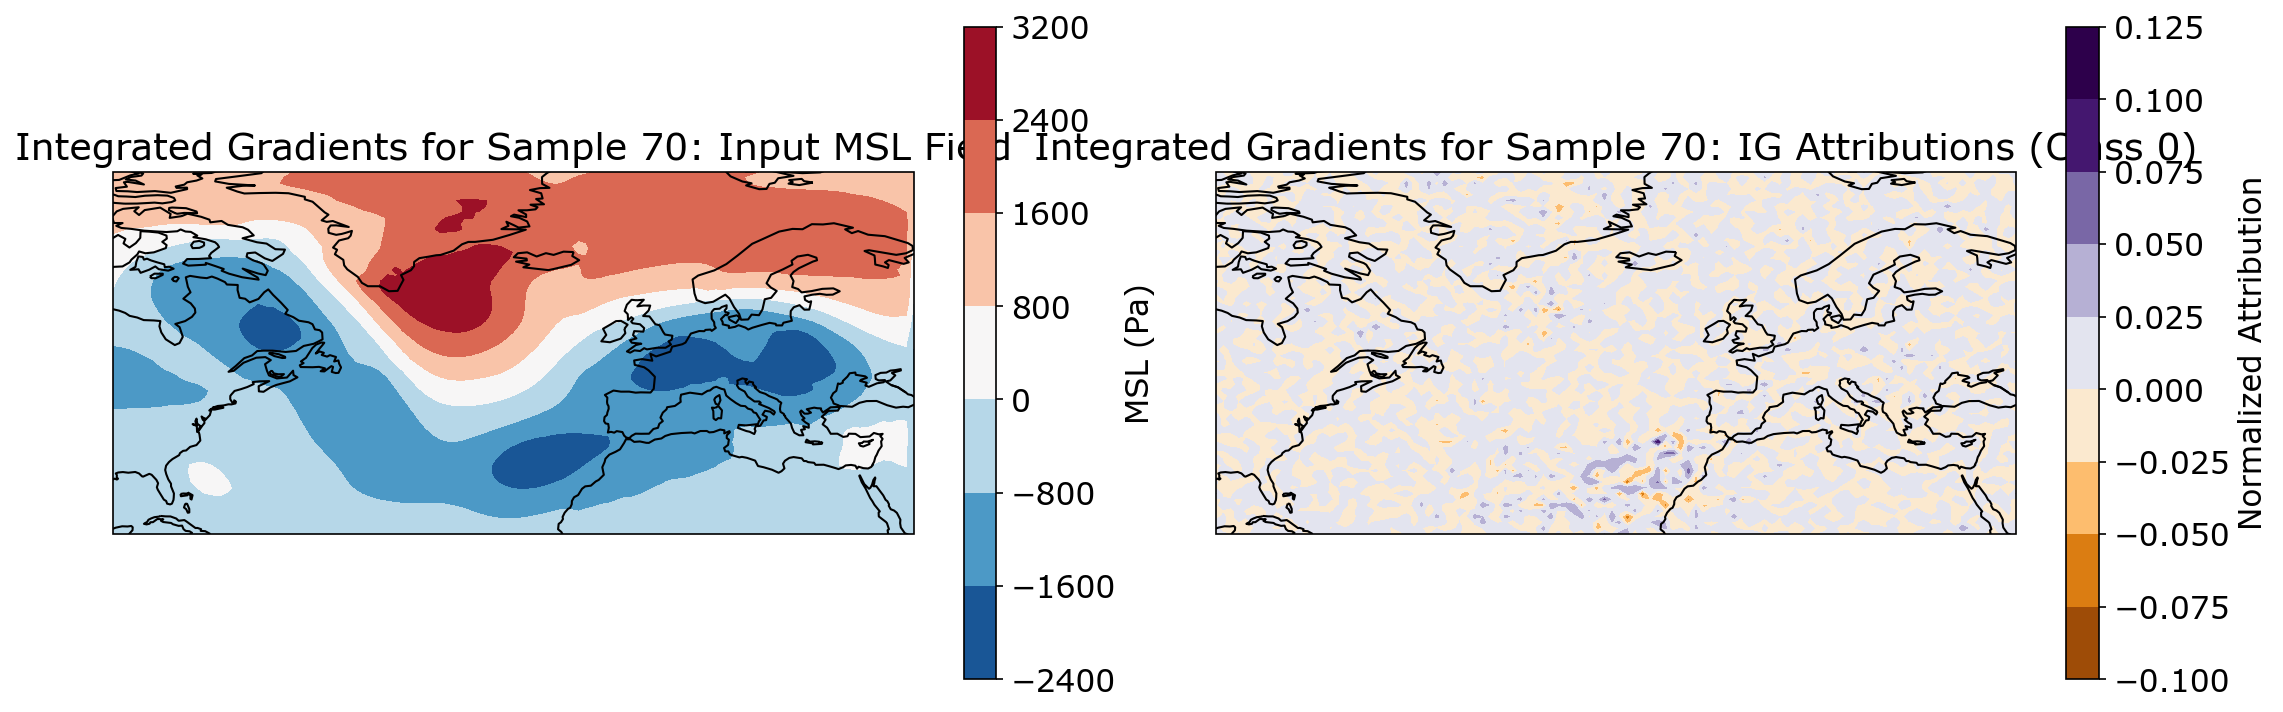

In [34]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import xarray as xr

# Integrated Gradients functions (from XAI_calcs_cluster_FOOs.ipynb)
def get_gradients(inputs, top_pred_idx=None):
    """Compute gradients of model output w.r.t. input."""
    inputs = tf.cast(inputs, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        preds = model(inputs, training=False)
        if top_pred_idx is not None:
            preds = preds[:, top_pred_idx]
    grads = tape.gradient(preds, inputs)
    return grads

def get_integrated_gradients(inputs, baseline=None, num_steps=50, top_pred_idx=None):
    """Compute Integrated Gradients for a specific input."""
    if baseline is None:
        baseline = np.zeros_like(inputs, dtype=np.float32)
    else:
        baseline = baseline.astype(np.float32)
    
    inputs = inputs.astype(np.float32)
    interpolated_inputs = [
        baseline + (step / num_steps) * (inputs - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_inputs = np.array(interpolated_inputs, dtype=np.float32)
    
    grads = []
    for x_data in interpolated_inputs:
        grad = get_gradients(x_data, top_pred_idx=top_pred_idx)
        grads.append(grad)
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)
    
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)
    integrated_grads = (inputs - baseline) * avg_grads
    
    return integrated_grads.numpy()

# Visualization function with normalized attributions
def plot_ig_map(input_data, ig_data, lat, lon, predicted_class, title_prefix="Integrated Gradients"):
    """Plot the msl field and normalized Integrated Gradients attributions."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Convert input_data to NumPy array if it's a DataArray
    if isinstance(input_data, xr.DataArray):
        input_data = input_data.values
    input_data = input_data.reshape(1, -1)  # Shape: (1, 6720)
    
    # Convert X_all_mean and X_all_std_dev to NumPy arrays and reshape to (64, 105)
    mean_2d = X_all_mean.values.reshape(len(lat), len(lon)) if isinstance(X_all_mean, xr.DataArray) else X_all_mean.reshape(len(lat), len(lon))
    std_2d = X_all_std_dev.values.reshape(len(lat), len(lon)) if isinstance(X_all_std_dev, xr.DataArray) else X_all_std_dev.reshape(len(lat), len(lon))
    
    # Adjust longitudes to [-180, 180]
    longitudes = lon.copy()
    longitudes = np.where(longitudes > 180, longitudes - 360, longitudes)
    
    # Sort longitudes and get sorting indices
    sorted_indices = np.argsort(longitudes)
    sorted_longitudes = longitudes[sorted_indices]
    
    # Reshape input_data to 2D and apply sorting
    input_2d = input_data.reshape(len(lat), len(lon))
    input_2d_sorted = input_2d[:, sorted_indices]
    
    # Reorder mean_2d and std_2d to match sorted longitudes
    mean_2d_sorted = mean_2d[:, sorted_indices]
    std_2d_sorted = std_2d[:, sorted_indices]
    
    # De-normalize input
    input_2d_sorted = (input_2d_sorted * std_2d_sorted) + mean_2d_sorted
    
    # Add cyclic point for plotting
    input_2d_sorted, cyclic_lons = add_cyclic_point(input_2d_sorted, coord=sorted_longitudes)
    
    # Plot original msl field
    im1 = ax1.contourf(cyclic_lons, lat, input_2d_sorted, cmap='RdBu_r', transform=ccrs.PlateCarree())
    ax1.add_feature(cfeature.COASTLINE)
    ax1.set_title(f"{title_prefix}: Input MSL Field")
    plt.colorbar(im1, ax=ax1, label="MSL (Pa)")
    
    # Reshape Integrated Gradients to 2D and apply sorting
    ig_2d = ig_data.reshape(len(lat), len(lon))
    ig_2d_sorted = ig_2d[:, sorted_indices]
    
    # Normalize IG attributions for better visualization
    ig_max = np.max(np.abs(ig_2d_sorted))
    if ig_max > 0:  # Avoid division by zero
        ig_2d_sorted = (ig_2d_sorted / ig_max) * 0.1  # Scale to [-0.1, 0.1]
    
    ig_2d_sorted, cyclic_lons = add_cyclic_point(ig_2d_sorted, coord=sorted_longitudes)
    
    # Plot Integrated Gradients with fixed range
    im2 = ax2.contourf(cyclic_lons, lat, ig_2d_sorted, cmap='PuOr', vmin=-0.1, vmax=0.1, transform=ccrs.PlateCarree())
    ax2.add_feature(cfeature.COASTLINE)
    ax2.set_title(f"{title_prefix}: IG Attributions (Class {predicted_class})")
    plt.colorbar(im2, ax=ax2, label="Normalized Attribution")
    
    plt.tight_layout()
    plt.show()

# Main script
# Verify shapes and ranges
print("X_val shape:", X_val.shape)
print("X_val range:", np.min(X_val.values if isinstance(X_val, xr.DataArray) else X_val), np.max(X_val.values if isinstance(X_val, xr.DataArray) else X_val))
print("X_all_mean shape:", X_all_mean.shape)
print("X_all_mean range:", np.min(X_all_mean.values if isinstance(X_all_mean, xr.DataArray) else X_all_mean), np.max(X_all_mean.values if isinstance(X_all_mean, xr.DataArray) else X_all_mean))
print("X_all_std_dev shape:", X_all_std_dev.shape)
print("X_all_std_dev range:", np.min(X_all_std_dev.values if isinstance(X_all_std_dev, xr.DataArray) else X_all_std_dev), np.max(X_all_std_dev.values if isinstance(X_all_std_dev, xr.DataArray) else X_all_std_dev))
print("Latitudes:", len(nao_data.latitude), "Longitudes:", len(nao_data.longitude))

# Select a sample
sample_idx = 70
sample_input = X_val[sample_idx:sample_idx+1]

# Convert sample_input to NumPy array for TensorFlow
if isinstance(sample_input, xr.DataArray):
    sample_input = sample_input.values

# Predict the class
pred = model.predict(sample_input)
predicted_class = np.argmax(pred, axis=1)[0]
print("Model prediction:", pred)

# Compute Integrated Gradients with X_all_mean as baseline
baseline = X_all_mean.values.reshape(1, -1) if isinstance(X_all_mean, xr.DataArray) else X_all_mean.reshape(1, -1)
ig_attributions = get_integrated_gradients(
    inputs=sample_input,
    baseline=baseline,
    num_steps=50,
    top_pred_idx=predicted_class
)

# Verify ig_attributions range and shape
print("ig_attributions shape:", ig_attributions.shape)
print("ig_attributions range:", np.min(ig_attributions), np.max(ig_attributions))

# Visualize the results
plot_ig_map(
    sample_input,
    ig_attributions,
    nao_data.latitude.values,
    nao_data.longitude.values,
    predicted_class,
    title_prefix=f"Integrated Gradients for Sample {sample_idx}"
)


In [30]:
# Main script
# Verify shapes
print("X_val shape:", X_val.shape)
print("X_all_mean shape:", X_all_mean.shape)
print("X_all_std_dev shape:", X_all_std_dev.shape)
print("Latitudes:", len(nao_data.latitude), "Longitudes:", len(nao_data.longitude))

# Select a sample
sample_idx = 8
sample_input = X_val[sample_idx:sample_idx+1]  # Shape: (1, 6720)

# Convert sample_input to NumPy array for TensorFlow
if isinstance(sample_input, xr.DataArray):
    sample_input = sample_input.values

# Predict the class
pred = model.predict(sample_input)
predicted_class = np.argmax(pred, axis=1)[0]

# Compute Integrated Gradients with random baselines
ig_attributions = random_baseline_integrated_gradients(
    inputs=sample_input,
    num_steps=50,
    num_runs=5,
    top_pred_idx=predicted_class
)

# Verify ig_attributions shape
print("ig_attributions shape:", ig_attributions.shape)

# Ensure longitude values are within the range [-180, 180] for Cartopy compatibility
longitudes = nao_data.longitude.values
longitudes = np.where(longitudes > 180, longitudes - 360, longitudes)

# Sort the data by longitude to ensure it is equally spaced
sorted_indices = np.argsort(longitudes)
longitudes = longitudes[sorted_indices]
sample_input_2d_sorted = sample_input_2d[:, sorted_indices]

# Visualize the results
plot_ig_map(
    sample_input_2d_sorted,
    ig_attributions,
    nao_data.latitude.values,
    longitudes,
    predicted_class,
    title_prefix=f"Integrated Gradients for Sample {sample_idx}"
)

X_val shape: (2492, 6720)
X_all_mean shape: (6720,)
X_all_std_dev shape: (6720,)
Latitudes: 64 Longitudes: 105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


NameError: name 'random_baseline_integrated_gradients' is not defined